In [1]:
import minari
import os
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import shimmy
from custom_dmc_tasks import point_mass_maze

from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise

from torch.utils.data import Dataset, DataLoader
os.environ['MUJOCO_GL'] = 'glfw'

In [2]:
task = 'reach_top_right'

In [3]:
def render_environment():
    raw_env = point_mass_maze.make(task=task)
    raw_env.reset()
    
    physics = raw_env.physics
    frame = physics.render(
            height=480, 
            width=480, 
            camera_id=0, 
            )

    plt.figure(figsize=(8, 8))
    plt.imshow(frame)
    plt.axis('off')
    plt.title("PointMass Maze")
    plt.show()


In [ ]:

raw_env = point_mass_maze.make(task=task)
env = shimmy.DmControlCompatibilityV0(raw_env)

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(
    mean=np.zeros(n_actions), 
    sigma=1 * np.ones(n_actions)
)

model = TD3(
    "MultiInputPolicy",
    env,
    learning_rate=1e-6,      # КРИТИЧНО: уменьшаем по Таблице 8
    buffer_size=1_000_000,
    batch_size=1024,         # По таблице (Common -> Batch Size)
    tau=0.01,                # Эквивалент EMA 0.99 (1 - 0.99)
    gamma=0.99,              # По таблице (Discount Factor)
    target_policy_noise=0.2, 
    target_noise_clip=0.3,
    policy_delay=1,          # Policy Update Frequency = 1
    verbose=0
)

# 5. Обучение
model.learn(total_timesteps=5_000_000, progress_bar=True)
model.save(f"td3_point_mass_expert_{task}")

Output()

Запуск агента и запись кадров...
GIF успешно сохранен: agent_trajectory.gif


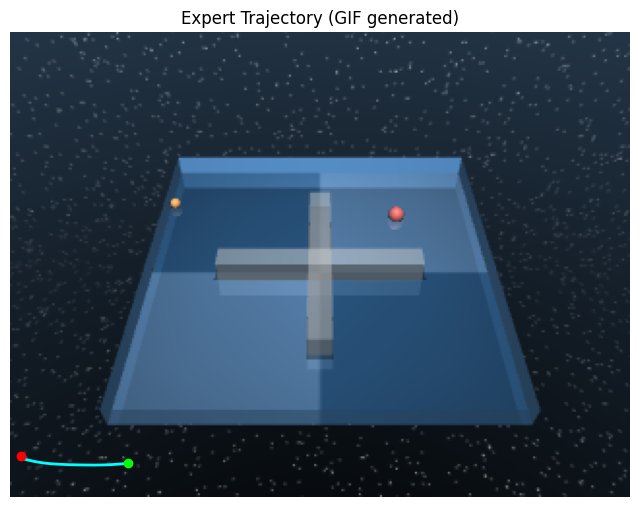

In [ ]:
import imageio
def create_agent_gif(model_path="td3_point_mass_expert", gif_name="agent_trajectory.gif"):
    # 1. Инициализация среды
    raw_env = point_mass_maze.make(task=task)
    env = shimmy.DmControlCompatibilityV0(raw_env, render_mode="rgb_array")
    
    # Загружаем модель
    model = TD3.load(model_path)
    
    obs, _ = env.reset()
    frames = []
    positions = []
    
    print("Запуск агента и запись кадров...")
    for _ in range(400): # 400 шагов достаточно для одного прохода
        frame = env.render()
        frames.append(frame)
        
        # Сохраняем позицию из словаря 'position'
        positions.append(obs['position'].copy())
        
        # Действие эксперта
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        
        if terminated or truncated:
            break

    # 2. Сохранение в GIF (максимально надежно)
    if frames:
        # Сохраняем с небольшой задержкой (duration в мс между кадрами)
        imageio.mimsave(gif_name, frames, duration=0.033, loop=0)
        print(f"GIF успешно сохранен: {gif_name}")
    else:
        print("Ошибка: список кадров пуст!")
        return

    # 3. Финальный статический график
    plt.figure(figsize=(8, 8))
    plt.imshow(frames[-1])
    
    pos_np = np.array(positions)
    h, w, _ = frames[-1].shape
    
    # Масштабирование: центр + координаты * коэффициент
    scale = w / 0.6 
    plot_x = (w / 2) + pos_np[:, 0] * scale
    plot_y = (h / 2) + pos_np[:, 1] * scale
    
    plt.plot(plot_x, plot_y, color='cyan', linewidth=2, label='Path')
    plt.scatter(plot_x[0], plot_y[0], c='lime', label='Start', zorder=5)
    plt.scatter(plot_x[-1], plot_y[-1], c='red', label='Goal', zorder=5)
    
    plt.title("Expert Trajectory (GIF generated)")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    create_agent_gif(gif_name=f"agent_trajectory_{task}.gif")